# Gridsearch CV, SVM , LR and AUC ROC

In [ ]:
# The target is categorical described in the notebook. Here GridsearCV with stratifiedKfold corss validation is used to find the best parameter for the prediction and predicting it with the best parameter. 

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Load dataset

In [2]:
train_file = './train.csv'
test_file = './test.csv'
sample_submission_file = './sample_submission.csv'

train_data = pd.read_csv(train_file)
X = train_data.drop('target', axis=1)
#Converting string to numerical data
y = train_data.target
#Converting string to numerical data
y = y.map( {'non_habitable': 0,'potentially_habitable': 1, 'very_habitable': 2})

X_test = pd.read_csv(test_file)

sample_submission = pd.read_csv(sample_submission_file)

## Pre-processing

### Check for missing values

In [3]:
X.isna().sum()

radiation_level       0
pressure              0
alien_prob            0
flare_prob            0
growth_potential    543
h2o                   0
dtype: int64

### Imputing missing values

In [4]:
si = SimpleImputer()

X = pd.DataFrame(si.fit_transform(X), columns=X.columns)
X_test = pd.DataFrame(si.transform(X_test), columns=X_test.columns)

X.isna().sum()

radiation_level     0
pressure            0
alien_prob          0
flare_prob          0
growth_potential    0
h2o                 0
dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array([0, 1, 2], dtype=int64)

In [6]:
X

,radiation_level,pressure,alien_prob,flare_prob,growth_potential,h2o
0,57.500,0.410,9.300,14.9500,3.000000,0.0
1,53.430,0.580,1.500,12.6850,2.900000,0.0
2,65.375,0.460,3.922,13.4600,2.541000,0.0
3,60.884,0.742,14.361,12.3385,3.724588,0.0
4,72.625,0.968,3.323,9.3230,4.144000,1.0
...,...,...,...,...,...,...
2484,84.750,0.447,10.100,13.9450,3.724588,0.0
2485,50.610,0.766,5.600,7.9950,3.724588,0.0
2486,47.000,0.757,-4.656,18.1330,3.836000,0.0
2487,26.953,0.978,1.977,5.0060,4.793000,1.0


## Train/test-split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.30, random_state=123, stratify=y)

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_val)
confmat = confusion_matrix(y_true=y_val, y_pred=y_pred)
print(confmat)

[[357   1   0]
 [  5 174  28]
 [  2  65 115]]


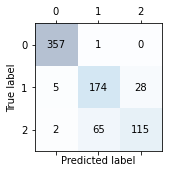

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV

def FDR(y, y_pred):
    C = confusion_matrix(y,y_pred)
    return C[0,1]/(C[0,1]+C[0,0]) #FP/(FP+TP)

FDR_score = make_scorer(FDR, greater_is_better=False)
print('False discovery rate: %.3f' % FDR(y_val, y_pred))

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_grid = [{'svc__C': param_range, 
               'svc__gamma': param_range2, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring=FDR_score, 
                  cv=10,
                  n_jobs=1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

False discovery rate: 0.003
0.0
{'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


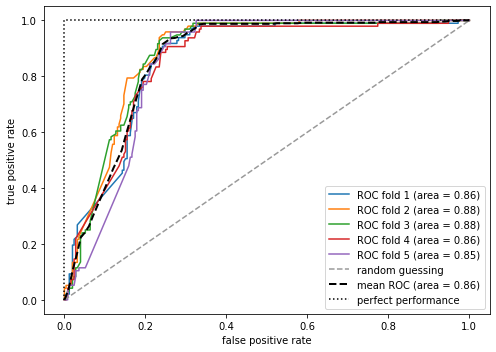

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from numpy import interp
import numpy as np

# Set up pipeline with scale, decomposer and classifyer
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0,
                                           solver='lbfgs'))
# Reduced variable set
X_train2 = X_train[:, [4,5]]
    
# Cross-validation specification
cv = list(StratifiedKFold(n_splits=5).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Loop through folds of CV
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test]) # Predict probability of classes

    # False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Model, Pipeline

In [12]:
std = StandardScaler()

model = LogisticRegression(random_state=12)

pipeline = make_pipeline(std, model)

param_grid = [
    {
        'logisticregression__penalty': ['none'],
    },
    {
        'logisticregression__penalty': ['l1','l2'],
        'logisticregression__C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
    }
]

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

best_estimator = grid.best_estimator_

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", 

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", 

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", 

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", 

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", 

{'logisticregression__penalty': 'none'}
nan


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", 

In [13]:
print(classification_report(y_val, best_estimator.predict(X_val)))
confmat = confusion_matrix(y_val, best_estimator.predict(X_val))
print(confmat)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       358
           1       0.70      0.85      0.77       207
           2       0.78      0.58      0.67       182

    accuracy                           0.85       747
   macro avg       0.82      0.81      0.81       747
weighted avg       0.86      0.85      0.85       747

[[356   1   1]
 [  3 175  29]
 [  2  74 106]]


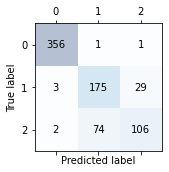

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

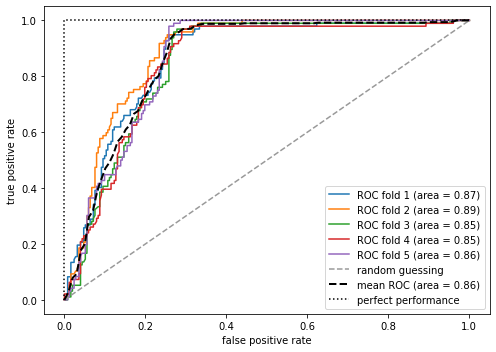

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from numpy import interp
import numpy as np

# Set up pipeline with scale, decomposer and classifyer
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0,
                                           solver='lbfgs'))
# Reduced variable set
X_train2 = X_train[:, [3,5]]
    
# Cross-validation specification
cv = list(StratifiedKFold(n_splits=5).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Loop through folds of CV
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test]) # Predict probability of classes

    # False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [16]:
best_estimator.fit(X, y)

y_hat = best_estimator.predict(X_test)

beatme_submission = sample_submission
beatme_submission['Predicted'] = y_hat

In [18]:
beatme_submission.to_csv('.beatme_submission.csv', index=False)

___